In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import torch
from torchfem import Truss

torch.set_default_dtype(torch.double)

# Sample truss

In [2]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

forces = torch.zeros_like(nodes)
forces[4, 1] = -0.1
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[5, 0] = True
A = 10 * torch.ones((len(elements)))
E = torch.ones((len(elements)))

truss_sample = Truss(nodes, elements, forces, displacements, constraints, A, E)

## Three bar truss

In [3]:
nodes = torch.tensor([[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]])
elements = torch.tensor([[0, 1], [0, 2], [1, 2]])
forces = torch.zeros_like(nodes)
forces[0, 1] = -0.2
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[1, 0] = True
constraints[1, 1] = True
constraints[2, 0] = True
A = torch.ones((len(elements)))
E = 10.0 * torch.ones((len(elements)))

three_bar_truss = Truss(nodes, elements, forces, displacements, constraints, A, E)

## The optimization

In [4]:
def newton(grad, mu_init, max_iter=10, tol=0.0001):
    # Newton's method to find root of grad (few iterations, if succesfull)
    mu = torch.tensor([mu_init], requires_grad=True)
    i = 0
    while torch.abs(grad(mu)) > tol:
        if i > max_iter:
            raise Exception(f"Newton solver did not converge in {max_iter} iterations.")
        gradgrad = torch.autograd.grad(grad(mu).sum(), mu)[0]
        mu.data -= grad(mu) / gradgrad
        mu.data = torch.max(mu.data, torch.tensor([0.0]))
        i += 1
    return mu.data


def bisection(grad, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if grad(a) * grad(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def compute_lengths(truss):
    start_nodes = truss.nodes[truss.elements[:, 0]]
    end_nodes = truss.nodes[truss.elements[:, 1]]
    dx = end_nodes - start_nodes
    return torch.linalg.norm(dx, dim=-1)


def optimize(truss, a_0, a_min, a_max, V_0, iter=10, s=0.7, p=1.0):
    k0 = truss.k() / truss.areas[:, None, None]
    a = [a_0]
    L = []
    l = compute_lengths(truss)

    # Check if there is a feasible solution before starting iteration
    if torch.inner(a_min, l) > V_0:
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the truss problem at point a_k
        truss.areas = a[k]
        u_k, f_k = truss.solve()

        # Get strain energy of all truss elements for the given displacement
        disp = u_k[truss.elements].reshape(-1, 4)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)

        # Compute lower asymptote
        if k <= 1:
            L.append(a[k] - s * (a_max - a_min))
        else:
            L_k = torch.zeros_like(L[k - 1])
            osci = (a[k] - a[k - 1]) * (a[k - 1] - a[k - 2]) < 0.0
            L_k[osci] = a[k][osci] - s * (a[k - 1][osci] - L[k - 1][osci])
            L_k[~osci] = a[k][~osci] - 1 / sqrt(s) * (a[k - 1][~osci] - L[k - 1][~osci])
            L.append(L_k)

        # Compute lower move limit in this step
        a_min_k = torch.max(a_min, 0.9 * L[k] + 0.1 * a[k])

        # Analytical solution
        def x_star(mu):
            a_hat = L[k] + torch.sqrt((2 * w_k * (L[k] - a[k]) ** 2) / (mu * l))
            return torch.clamp(a_hat, a_min_k, a_max)

        # Analytical gradient
        def grad(mu):
            return torch.dot(x_star(mu), l) - V_0

        # Solve dual problem
        # mu_star = newton(grad, 1.0)
        mu_star = bisection(grad, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        a.append(x_star(mu_star))

    return a

## Example 28 - Optimization of the three bar truss

Iteration k=0 - Compliance: 0.07790
Iteration k=1 - Compliance: 0.04519
Iteration k=2 - Compliance: 0.03783
Iteration k=3 - Compliance: 0.03750
Iteration k=4 - Compliance: 0.03749
Iteration k=5 - Compliance: 0.03749
Iteration k=6 - Compliance: 0.03749
Iteration k=7 - Compliance: 0.03749
Iteration k=8 - Compliance: 0.03749
Iteration k=9 - Compliance: 0.03749


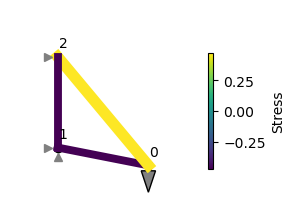

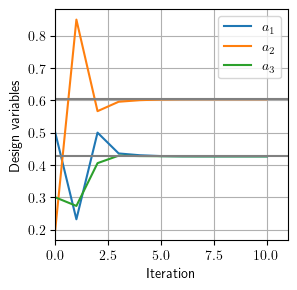

In [5]:
# Limits on design variables
a_0 = torch.tensor([0.5, 0.2, 0.3])
a_min = 0.1 * torch.ones_like(a_0)
a_max = 1.0 * torch.ones_like(a_0)
# Compute volume restriction
l = compute_lengths(three_bar_truss)
V0 = 0.5 * torch.inner(a_max, l)

a_opt = optimize(three_bar_truss, a_0, a_min, a_max, V0)
u, f = three_bar_truss.solve()
sigma = three_bar_truss.compute_stress(u)

plt.figure(figsize=(3, 3))
three_bar_truss.plot(u=u, sigma=sigma, show_thickness=True)
plt.savefig(
    "../figures/three_bar_truss_size_optimized.svg",
    transparent=True,
    bbox_inches="tight",
)
plt.show()

plt.rcParams["text.usetex"] = True

l = compute_lengths(three_bar_truss)
plt.figure(figsize=(3, 3))
plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.axhline(0.25 * V0, color="gray")
plt.axhline(0.3535 * V0, color="gray")
plt.legend(["$a_1$", "$a_2$", "$a_3$"])
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
plt.savefig(
    "../figures/three_bar_truss_variables.svg", transparent=True, bbox_inches="tight"
)
plt.show()

## Example 29 - Optimization of the sample truss

Iteration k=0 - Compliance: 0.10004
Iteration k=1 - Compliance: 0.03018
Iteration k=2 - Compliance: 0.03039
Iteration k=3 - Compliance: 0.02945
Iteration k=4 - Compliance: 0.02928
Iteration k=5 - Compliance: 0.02899
Iteration k=6 - Compliance: 0.02892
Iteration k=7 - Compliance: 0.02888
Iteration k=8 - Compliance: 0.02884
Iteration k=9 - Compliance: 0.02882
Iteration k=10 - Compliance: 0.02882
Iteration k=11 - Compliance: 0.02882
Iteration k=12 - Compliance: 0.02882
Iteration k=13 - Compliance: 0.02882
Iteration k=14 - Compliance: 0.02882
Iteration k=15 - Compliance: 0.02882
Iteration k=16 - Compliance: 0.02882
Iteration k=17 - Compliance: 0.02882
Iteration k=18 - Compliance: 0.02882
Iteration k=19 - Compliance: 0.02882
Iteration k=20 - Compliance: 0.02882
Iteration k=21 - Compliance: 0.02882
Iteration k=22 - Compliance: 0.02882
Iteration k=23 - Compliance: 0.02882
Iteration k=24 - Compliance: 0.02882
Iteration k=25 - Compliance: 0.02882
Iteration k=26 - Compliance: 0.02882
Iteration k

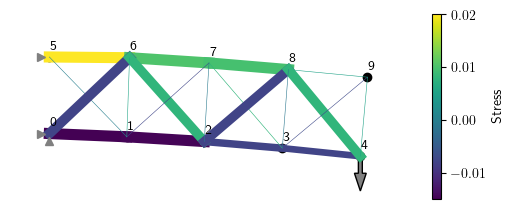

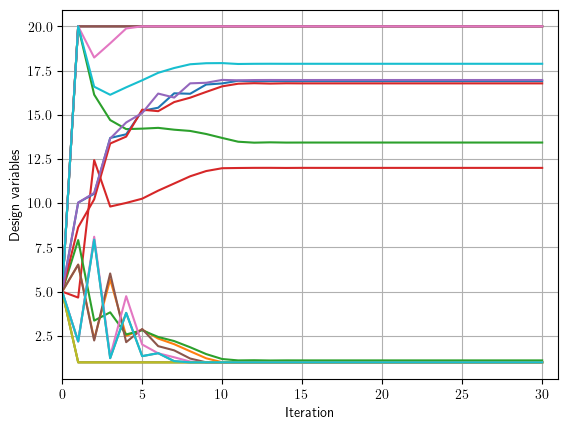

In [6]:
a_0 = 5.0 * torch.ones((len(truss_sample.elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 20.0 * torch.ones_like(a_0)
# Compute volume restriction
l = compute_lengths(truss_sample)
V0 = 0.5 * torch.inner(a_max, l)

a_opt = optimize(truss_sample, a_0, a_min, a_max, V0, iter=30)
u, f = truss_sample.solve()
sigma = truss_sample.compute_stress(u)
truss_sample.plot(u=u, sigma=sigma, show_thickness=True, node_labels=True)
plt.savefig(
    "../figures/truss_sample_size_optimized.svg", transparent=True, bbox_inches="tight"
)
plt.show()

# plt.rcParams["text.usetex"] = True

plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
# plt.savefig("../figures/truss_sample_variables.svg", transparent=True)
plt.show()

## Example 30 - Large truss optimization

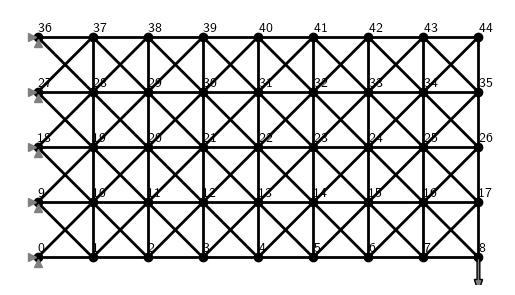

In [7]:
A = 9
B = 5
n1 = torch.linspace(0.0, A - 1.0, A)
n2 = torch.linspace(0.0, B - 1.0, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = []
for i in range(A - 1):
    for j in range(B):
        elements.append([i + j * A, i + 1 + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elements.append([i + 1 + j * A, i + 1 + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elements.append([i + j * A, i + 1 + A + j * A])
        elements.append([i + 1 + j * A, i + A + j * A])
elements = torch.tensor(elements)

forces = torch.zeros_like(nodes)
forces[A - 1, 1] = -0.1
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
for i in range(B):
    constraints[i * A, 0] = True
    constraints[i * A, 1] = True
A = 10.0 * torch.ones((len(elements)))
E = 100.0 * torch.ones((len(elements)))

large_truss = Truss(nodes, elements, forces, displacements, constraints, A, E)
large_truss.plot()
plt.savefig("../figures/large_truss.svg", transparent=True, bbox_inches="tight")

## Optimization

Iteration k=0 - Compliance: 0.00018
Iteration k=1 - Compliance: 0.00030
Iteration k=2 - Compliance: 0.00037
Iteration k=3 - Compliance: 0.00121
Iteration k=4 - Compliance: 0.00042
Iteration k=5 - Compliance: 0.00035
Iteration k=6 - Compliance: 0.00120
Iteration k=7 - Compliance: 0.00036
Iteration k=8 - Compliance: 0.00049
Iteration k=9 - Compliance: 0.00093
Iteration k=10 - Compliance: 0.00041
Iteration k=11 - Compliance: 0.00039
Iteration k=12 - Compliance: 0.00046
Iteration k=13 - Compliance: 0.00047
Iteration k=14 - Compliance: 0.00031
Iteration k=15 - Compliance: 0.00058
Iteration k=16 - Compliance: 0.00042
Iteration k=17 - Compliance: 0.00041
Iteration k=18 - Compliance: 0.00035
Iteration k=19 - Compliance: 0.00032
Iteration k=20 - Compliance: 0.00035
Iteration k=21 - Compliance: 0.00038
Iteration k=22 - Compliance: 0.00034
Iteration k=23 - Compliance: 0.00031
Iteration k=24 - Compliance: 0.00031
Iteration k=25 - Compliance: 0.00033
Iteration k=26 - Compliance: 0.00030
Iteration k

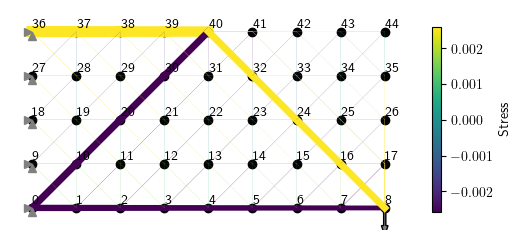

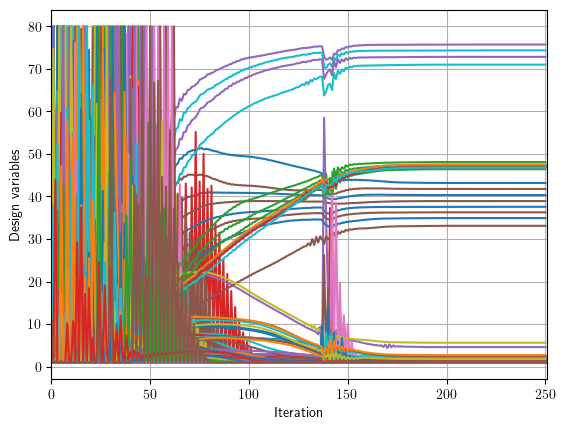

In [8]:
a_0 = 10.0 * torch.ones((len(elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 80.0 * torch.ones_like(a_0)
l = compute_lengths(large_truss)
V0 = 0.1 * torch.inner(a_max, l)

a_opt = optimize(large_truss, a_0, a_min, a_max, V0, iter=250, s=0.9)
u, f = large_truss.solve()
sigma = large_truss.compute_stress(u)
large_truss.plot(u=u, sigma=sigma, show_thickness=True, node_labels=True)
plt.savefig(
    "../figures/large_truss_size_optimized.svg", transparent=True, bbox_inches="tight"
)
plt.show()

plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
plt.show()

## Figure 5.4 - Bridge

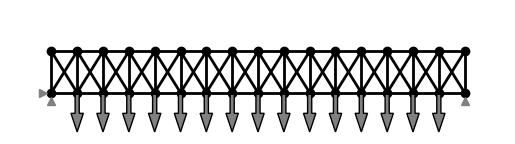

In [9]:
# Dimensions
A = 17
B = 2

# Nodes
n1 = torch.linspace(0.0, 5.0, A)
n2 = torch.linspace(0.0, 0.5, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Elements
elements = []
for i in range(A - 1):
    for j in range(B):
        elements.append([i + j * A, i + 1 + j * A])
for i in range(A):
    for j in range(B - 1):
        elements.append([i + j * A, i + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elements.append([i + j * A, i + 1 + A + j * A])
        elements.append([i + 1 + j * A, i + A + j * A])
elements = torch.tensor(elements)

# Forces at bottom edge
displacements = torch.zeros_like(nodes)
forces = torch.zeros_like(nodes)
forces[1 : A - 1, 1] = -0.1

# Constraints by the supports
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[A - 1, 1] = True

# Areas
areas = torch.ones((len(elements)))
E = 500.0 * torch.ones((len(elements)))

# Truss
bridge = Truss(nodes.clone(), elements, forces, displacements, constraints, areas, E)
bridge.plot(node_labels=False)

Iteration k=0 - Compliance: 0.00453
Iteration k=1 - Compliance: 0.00708
Iteration k=2 - Compliance: 0.03957
Iteration k=3 - Compliance: 0.00572
Iteration k=4 - Compliance: 0.03565
Iteration k=5 - Compliance: 0.01128
Iteration k=6 - Compliance: 0.01516
Iteration k=7 - Compliance: 0.02055
Iteration k=8 - Compliance: 0.01574
Iteration k=9 - Compliance: 0.01347
Iteration k=10 - Compliance: 0.01018
Iteration k=11 - Compliance: 0.02114
Iteration k=12 - Compliance: 0.01706
Iteration k=13 - Compliance: 0.01118
Iteration k=14 - Compliance: 0.00921
Iteration k=15 - Compliance: 0.01644
Iteration k=16 - Compliance: 0.02157
Iteration k=17 - Compliance: 0.00634
Iteration k=18 - Compliance: 0.00760
Iteration k=19 - Compliance: 0.00673
Iteration k=20 - Compliance: 0.01893
Iteration k=21 - Compliance: 0.01405
Iteration k=22 - Compliance: 0.00828
Iteration k=23 - Compliance: 0.01210
Iteration k=24 - Compliance: 0.01183
Iteration k=25 - Compliance: 0.00624
Iteration k=26 - Compliance: 0.01245
Iteration k

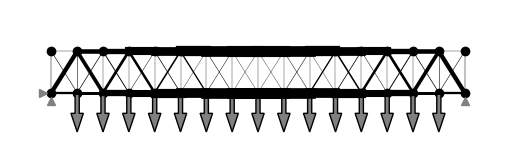

In [10]:
a_0 = 10.0 * torch.ones((len(elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 80.0 * torch.ones_like(a_0)
l = compute_lengths(bridge)
V0 = 0.1 * torch.inner(a_max, l)

a_opt = optimize(bridge, a_0, a_min, a_max, V0, iter=250, s=0.9)
bridge.plot(show_thickness=True, node_labels=False)
plt.savefig(
    "../figures/bridge_size_optimized.svg", transparent=True, bbox_inches="tight"
)
plt.show()